In [232]:
import os

import pprint
import hearttools
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm

PATH_TO_CORONARY_MAT = os.path.join(os.getcwd(), 'lab_data', 'coronary.mat')

Documentation for the `hearttools` module is available [here](https://github.com/vtrno/PyGBM6700E/wiki/hearttools%E2%80%90docs). Read it, **many** helpful functions are already defined here !  
**Read the `TODO` comments**, they're here to help !  
If you see a `pass` statement, remove it and put your code instead

In [233]:
mesh = hearttools.io.load_mesh(PATH_TO_CORONARY_MAT) # ? Load our data

In [234]:
# TODO : Plot the mesh to understand its structure. Take a look at the documentation of 'Mesh' objects 😉
mesh.plot()

# Question 1

Starting from the CT volume of the left coronary artery (in fact, from the 3D skeleton already extracted), simulate two angiographic views of the left coronary artery (its skeleton) by choosing the DICOM parameters based on the information provided in APPENDIX B. Display the two images obtained. The resulting images will be those to use in the following questions.

In [235]:
def calculate_2d_projection(points_3d:np.ndarray, proj_mat:np.ndarray) -> np.ndarray:
    """
    Calculates 2D projection of an array of 3D points

    Parameters
    ----------
    points_3d : np.ndarray
        Array of 3D points, shape (n_points, 3)
    proj_mat : np.ndarray
        Projection matrix, shape (3, 4)

    Returns
    -------
    np.ndarray
        Projection of the points, shape (n_points, 2)
    """
    # First convert points to homogeneous coordinates, see `hearttools.geometry.to_homogeneous()`
    # Then we matmul the projection matrix and the points
    # Finally, we normalize by dividing each point by the 3rd coordinates and wee keep only the 2 first.
    
    points_3d_homogeneous = hearttools.geometry.to_homogeneous(points_3d) 
    projected_points = np.matmul(proj_mat, np.transpose(points_3d_homogeneous))
    projected_points = np.transpose(projected_points)
    points_normalised = projected_points[:, 0:2] / projected_points[:, 2][:, np.newaxis]
    return points_normalised

In [236]:
# TODO : define these
sid, sod, dp = 1050, 750, 0.1953 
alpha_0, beta_0 = -30, -25 # ? For view 1
alpha_1, beta_1 = 45, 30 # ? For view 2
image_size = 1024

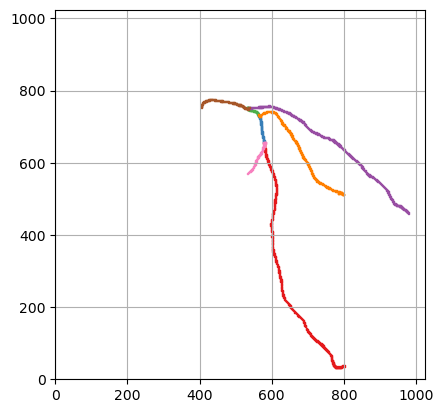

In [237]:
params_1 = hearttools.geometry.build_view_geometry(sid, sod, dp, alpha_0, beta_0, (image_size, image_size))
pmat = params_1['source']['P']
view_1_pts_2d = calculate_2d_projection(mesh.skeleton, pmat)
fig = hearttools.plot.imshow(view_1_pts_2d, (image_size, image_size), mesh.skeleton_labels)

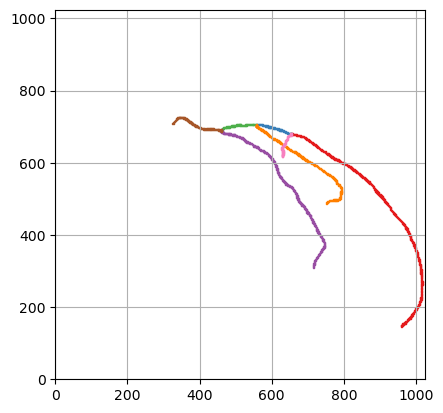

In [238]:
# TODO : do the same thing for view 2
params_2 = hearttools.geometry.build_view_geometry(sid, sod, dp, alpha_1, beta_1, (image_size, image_size))
pmat = params_2['source']['P']
view_2_pts_2d = calculate_2d_projection(mesh.skeleton, pmat)
fig = hearttools.plot.imshow(view_2_pts_2d, (image_size, image_size), mesh.skeleton_labels)

Calculate the fundamental matrix (F) relating the two viewpoints, following three methods:  
a) directly from the known calibration parameters;  
b) using the 8-point algorithm (with provided function), with a set of 8 corresponding points from the two images;  
c) using the 8-point algorithm, but with all the available corresponding points from the two
images

In [239]:
# TODO : Implement Method A

# See complementary slides
R, T = params_1['source']['R'], params_1['source']['T']
R_prime, T_prime = params_2['source']['R'], params_2['source']['T']

A = np.concatenate((R, T), axis=1)
A_prime = np.concatenate((R_prime, T_prime), axis=1)
A = np.vstack([A, [0, 0, 0, 1]])
A_prime = np.vstack([A_prime, [0, 0, 0, 1]])

A_s = np.matmul(A_prime, np.linalg.inv(A))

R_s = A_s[:3, :3]
T_s = A_s[:3, 3]

T_s_x = np.array([[0, -T_s[2], T_s[1]],
                  [T_s[2], 0, -T_s[0]],
                  [-T_s[1], T_s[0], 0]])

E = np.matmul(T_s_x, R_s)

K, K_prime = params_1['source']['K'], params_2['source']['K']

F_MethodA = np.matmul( np.transpose(np.linalg.inv(K_prime)), np.matmul(E, np.linalg.inv(K)) )   # F = (K’-1)^t.E.K-1

In [240]:
#Implement Method B
# HINT : for selecting your 8 points, take the branches extremities.

change_points = np.where(np.diff(mesh.skeleton_labels) != 0)[0]
extremities_indices = np.concatenate([change_points, change_points + 1])
_, unique_indices = np.unique(mesh.skeleton[extremities_indices], axis=0, return_index=True)
unique_extremities_indices = extremities_indices[unique_indices]
unique_extremities_indices = np.sort(np.append([unique_extremities_indices], 0))

extremities_view_1 = view_1_pts_2d[unique_extremities_indices]
extremities_view_2 = view_2_pts_2d[unique_extremities_indices]

F_MethodB = hearttools.geometry.compute_8points_algorithm(extremities_view_1, extremities_view_2)

In [241]:
# TODO : Implement Method C
# Same thing as method B but with all the points

F_MethodC = hearttools.geometry.compute_8points_algorithm(view_1_pts_2d, view_2_pts_2d)


In [242]:
print(f'F method A = \n{F_MethodA}')
print(f'F method B = \n{F_MethodB}')
print(f'F method C = \n{F_MethodC}')

print()

print(f'F normalized method A = \n{F_MethodA/F_MethodA[-1][-1]}')
print(f'F normalized method B = \n{F_MethodB/F_MethodB[-1][-1]}')
print(f'F normalized method C = \n{F_MethodC/F_MethodC[-1][-1]}')


F method A = 
[[ 2.31234684e-05 -1.22307851e-05  6.18409259e-02]
 [-1.22307851e-05 -2.31234684e-05 -1.04020563e-01]
 [-8.20064792e-02  1.34795402e-01  9.80499434e-01]]
F method B = 
[[-2.41916665e-07  1.27957913e-07 -6.46976929e-04]
 [ 1.27957913e-07  2.41916665e-07  1.08825835e-03]
 [ 8.57948022e-04 -1.41022331e-03 -1.02579401e-02]]
F method C = 
[[ 2.59505856e-08 -1.37261431e-08  6.94017097e-05]
 [-1.37261431e-08 -2.59505856e-08 -1.16738306e-04]
 [-9.20327401e-05  1.51275733e-04  1.10037707e-03]]

F normalized method A = 
[[ 2.35833572e-05 -1.24740359e-05  6.30708431e-02]
 [-1.24740359e-05 -2.35833572e-05 -1.06089366e-01]
 [-8.36374570e-02  1.37476267e-01  1.00000000e+00]]
F normalized method B = 
[[ 2.35833572e-05 -1.24740359e-05  6.30708431e-02]
 [-1.24740359e-05 -2.35833572e-05 -1.06089366e-01]
 [-8.36374570e-02  1.37476267e-01  1.00000000e+00]]
F normalized method C = 
[[ 2.35833572e-05 -1.24740359e-05  6.30708431e-02]
 [-1.24740359e-05 -2.35833572e-05 -1.06089366e-01]
 [-8.36374

# Question 2  
1) Select one of your images as View 1 and the other as View 2;
2) Resample the branches in View 2 to double the density of points (using the provided
function);
3) For each point in each branch in View 1:  
    a. Compute the epipolar line in View 2  
    b. Find the closest point in View 2 to that line  
    c. Retain that point as the match for the point in View1 

Keep the obtained sets of corresponding 2D points for the subsequent questions. For illustration
purposes, provide two figures showing examples of the epipolar lines for a selected branch, in
each of the two views. (For the epipolar lines in View 1, these are the conjugates of those in
View 2).  
Also answer the following questions:
1) What can you observe in the figures showing the epipolar lines?
2) In general, why is it useful to use the resampling + epipolar constraint approach to
find matching points in curvilinear structures (e.g. in medical images)?

HINT : https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision)

In [243]:
def distance_point_to_line(line_equation:tuple, point_coordinates:tuple) -> float:
    """
    Calculates the distance between a line and a point

    Parameters
    ----------
    line_equation : tuple
        a, b, c coefficients such as ax+by+c = 0
    point_coordinates : tuple
        x_0, y_0 coordinates of the point

    Returns
    -------
    float
        Orthogonal distance to the line
    """
    # HINT : https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    a, b, c = line_equation[0], line_equation[1], line_equation[2]
    x_0, y_0 = point_coordinates[0], point_coordinates[1]
    return abs(a*x_0 + b*y_0 + c)/np.sqrt(a**2 + b**2)

In [244]:
def find_closest_point_to_line(line_equation: tuple, pts: np.ndarray) -> np.ndarray:
    """
    Find the point in pts that is closest to the line.
    
    Args:
        line_equation: A tuple representing the line (A, B, C) where the line equation is Ax + By + C = 0.
        pts: A numpy array of shape (N, 2) where each row is a point (x, y).
    
    Returns:
        The point (x, y) from pts that is closest to the line.
    """
    
    min_distance = float('inf')
    closest_point = None

    for point in pts:
        distance = distance_point_to_line(line_equation, tuple(point))
        if distance < min_distance:
            min_distance = distance
            closest_point = point

    return closest_point

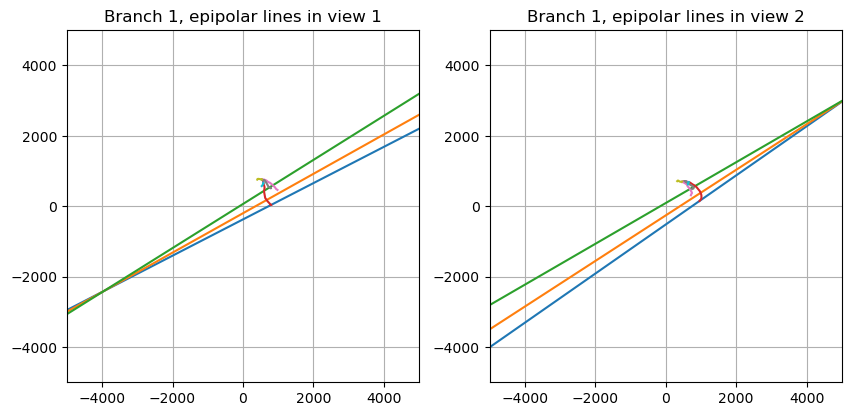

In [245]:
"""
FIGURE SETUP, DO NOT TOUCH
"""
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].set_title("Branch 1, epipolar lines in view 1")
ax[1].set_title("Branch 1, epipolar lines in view 2")

for a in [ax[0], ax[1]]:
    a.set_aspect('equal', adjustable='box') # ? Set the aspect ratio
    a.grid() # ? Add the grid
    a.set_xlim(-5000, 5000) # ? Set the limits
    a.set_ylim(-5000, 5000)
"""
END OF FIGURE SETUP
"""

# TODO : Sample view 1
sampled_view_1 = np.empty((0, 2))  # Assuming pts is 2D, so shape (0, 2)
sampled_view_1_labels = np.empty(0)  # 1D array for labels
for branch_idx in np.unique(mesh.skeleton_labels): # ? For each branch idx
    pts = view_1_pts_2d[mesh.skeleton_labels == branch_idx] # ? Select the corresponding points (ie. where the label of the point corresponds to the branch_idx)
    # TODO : double the point density for each branch, then use the interpolation function to... interpolate. Don't forget to also save the labels of your newly created points !
    branch_pts_doubled = hearttools.utils.interpolate(pts, len(pts)*2)
    branch_labels_doubled = branch_idx*np.ones(len(branch_pts_doubled))
    sampled_view_1 = np.concatenate((sampled_view_1, branch_pts_doubled), axis=0)
    sampled_view_1_labels = np.concatenate((sampled_view_1_labels, branch_labels_doubled), axis=0)


# TODO : Do the same thing for view 2   
sampled_view_2 = np.empty((0, 2))  # Assuming pts is 2D, so shape (0, 2)
sampled_view_2_labels = np.empty(0)  # 1D array for labels
for branch_idx in np.unique(mesh.skeleton_labels): # ? For each branch idx
    pts = view_2_pts_2d[mesh.skeleton_labels == branch_idx] # ? Select the corresponding points (ie. where the label of the point corresponds to the branch_idx)
    # TODO : double the point density for each branch, then use the interpolation function to... interpolate. Don't forget to also save the labels of your newly created points !
    branch_pts_doubled = hearttools.utils.interpolate(pts, len(pts)*2)
    branch_labels_doubled = branch_idx*np.ones(len(branch_pts_doubled))
    sampled_view_2 = np.concatenate((sampled_view_2, branch_pts_doubled), axis=0)
    sampled_view_2_labels = np.concatenate((sampled_view_2_labels, branch_labels_doubled), axis=0)

# ? Now we find the matching points 
"""
For each point in view 1 :
    - compute the epipolar lines using the fundamental matrix.
    - then find the closest point to the epipolar line in resampled view 2
    - store that pair (point_v1, point_v2_resampled) : you just did epipolar matching !
"""
F = F_MethodA # The fundamental matrix calculated using method A for example

pairs = np.empty((0, 2, 2))
for branch_idx in np.unique(mesh.skeleton_labels):
    for Pview1 in hearttools.geometry.to_homogeneous(view_1_pts_2d[mesh.skeleton_labels == branch_idx]):
        Pview1 = Pview1.reshape(-1, 1)
        epipolar_line = np.matmul(F, Pview1)
        epipolar_line = epipolar_line.flatten()
        matching_point = find_closest_point_to_line(tuple(epipolar_line), sampled_view_2[sampled_view_2_labels == branch_idx])
        new_pair = np.array([[Pview1[0, 0], Pview1[1, 0]], matching_point])
        pairs = np.concatenate((pairs, new_pair[np.newaxis]), axis=0)
    
    
"""
Now plot a few epipolar lines on the first branch in both views. Use the predefined limits (-5000, 5000) setup in the beginning of this code cell.
"""

def calculate_epipolar_lines(F, points):
    return np.transpose(np.matmul(F, np.transpose(hearttools.geometry.to_homogeneous(points)))) 

epipolar_lines_view2 = calculate_epipolar_lines(F, hearttools.utils.sample_n_points(view_1_pts_2d[mesh.skeleton_labels == 0], 3)) # F.PView1 is the epipolar line associated to PView1, in View 2
epipolar_lines_view1 = calculate_epipolar_lines(F.T, hearttools.utils.sample_n_points(view_2_pts_2d[mesh.skeleton_labels == 0], 3)) # F.PView2 is the epipolar line associated to PView2, in View 1


# TODO : YOUR CODE GOES HERE

def plot_line(ax, line):
    x_vals = np.linspace(-5000, 5000, 100)
    a, b, c = line 
    y_vals = -(a * x_vals + c) / b
    ax.plot(x_vals, y_vals)
    
for epline in epipolar_lines_view1:
    plot_line(ax[0], epline)
    
for epline in epipolar_lines_view2:
    plot_line(ax[1], epline)
    
# Plot coronary branches
for branch_idx in np.unique(mesh.skeleton_labels): 
    pts1 = view_1_pts_2d[mesh.skeleton_labels == branch_idx]
    ax[0].plot(pts1[:,0], pts1[:,1])
    pts2 = view_2_pts_2d[mesh.skeleton_labels == branch_idx]
    ax[1].plot(pts2[:,0], pts2[:,1])
        
plt.show()

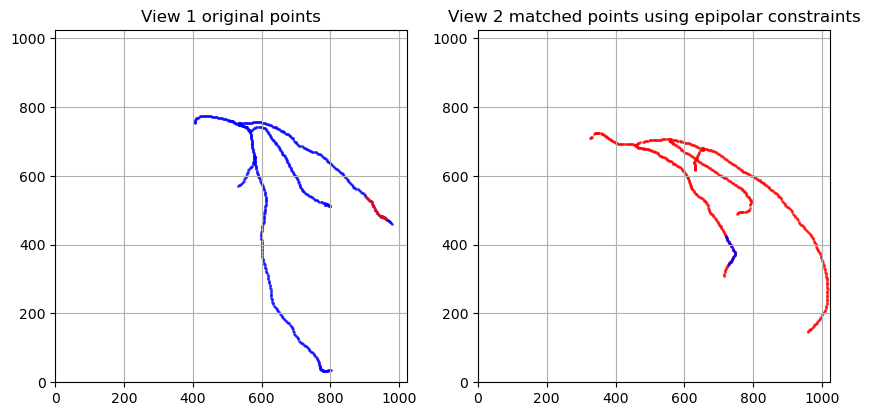

In [246]:

"""
FIGURE SETUP, DO NOT TOUCH
"""
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].set_title("View 1 original points")
ax[1].set_title("View 2 matched points using epipolar constraints")

for a in [ax[0], ax[1]]:
    a.set_aspect('equal', adjustable='box')
    a.grid()
    a.set_xlim(0, image_size)
    a.set_ylim(0, image_size)
"""
END OF FIGURE SETUP
"""

# TODO : plot both the original view 1 points, and the matched points using epipolar constraints in view 2

view1_points = pairs[:, 0, :]  # Original points from View 1
view2_points = pairs[:, 1, :]  # Matched points from View 2

# Plot original points in View 1
ax[0].scatter(view1_points[:, 0], view1_points[:, 1], color='blue', label='View 1 Points', alpha=0.5, s=1.5)
# Plot matched points in View 2
ax[1].scatter(view2_points[:, 0], view2_points[:, 1], color='red', label='Matched View 2 Points', alpha=0.5, s=1.5)


# Plot a section to compare
section = slice(280, 310)
view1_points1 = pairs[section, 0, :]
view2_points1 = pairs[section, 1, :]  
ax[0].scatter(view1_points1[:, 0], view1_points1[:, 1], color='red', label='View 1 Points', alpha=0.5, s=1.5)
ax[1].scatter(view2_points1[:, 0], view2_points1[:, 1], color='blue', label='Matched View 2 Points', alpha=0.5, s=1.5)


plt.show()

# Question 3
In the case of a stereoscopic system that is not fully calibrated, calculating a depth map can
provide a first approximation of the 3D shape of an object in the scene. In this question, you will
construct such a depth map and compare it to the real 3D structure of the coronary tree.
Construct the depth map of the vessel central lines with the following steps:
1) Compute the disparity between the pairs of corresponding points obtained in Question 2
2) Compute the depth Z at each point in View 1

Next, construct another version of the depth map, by first rectifying the two images (using the
provided function), recalculating the disparities between point pairs and recalculating the Z map.  

Display as 2D figures with color maps: first the disparity maps, then the depth maps in each case.  

Now, construct the real (ground truth) depth map of the vessels skeleton. To do this, you must
first use the known geometric system parameters to transform the reference model to the
coordinate frame of the 1st source. Consider the Z coordinates of the transformed model as the
depth map. Display this depth map similarly to the previous ones.  

Compare the different figures (maps) obtained qualitatively (visually): do they make sense?  

When compared to the real depth map, which of the maps computed from disparities is most
similar to the ground truth? Discuss your results

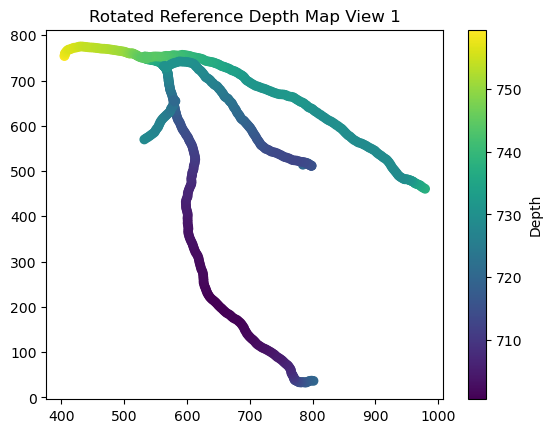

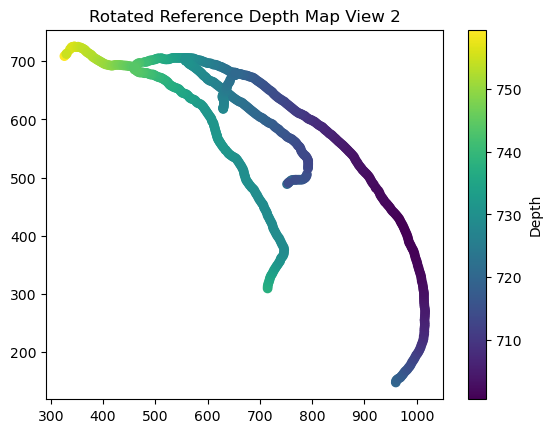

In [247]:
# ? Show the reference depth map
# TODO : calculate the transformation matrix to rotate the 3D reference points such as the Z-axis is orthogonal to the camera plane. Then show the depth map
#Z=f*B/d
#d : disparity (between pairs of points)
#B : B = distance between the sources
#f : focal length

#Z=(f*B)/d  # Depth Z = f * B / d
R_camera = params_1['source']['R']
T_camera = params_1['source']['T']
R_camera = np.concatenate((R_camera, T_camera), axis=1)
rotated_points = (R_camera @ hearttools.geometry.to_homogeneous(mesh.skeleton).T).T

depth_map_reference = rotated_points[:, 2]

plt.figure()
plt.scatter(view1_points[:, 0], view1_points[:, 1], c=depth_map_reference, cmap='viridis')
plt.colorbar(label='Depth')
plt.title("Rotated Reference Depth Map View 1")
plt.show()
plt.figure()
plt.scatter(view2_points[:, 0], view2_points[:, 1], c=depth_map_reference, cmap='viridis')
plt.colorbar(label='Depth')
plt.title("Rotated Reference Depth Map View 2")
plt.show()

1064.9819353295518
B, correlation metrics between real depth and estimated depth:
1064.9819353295518


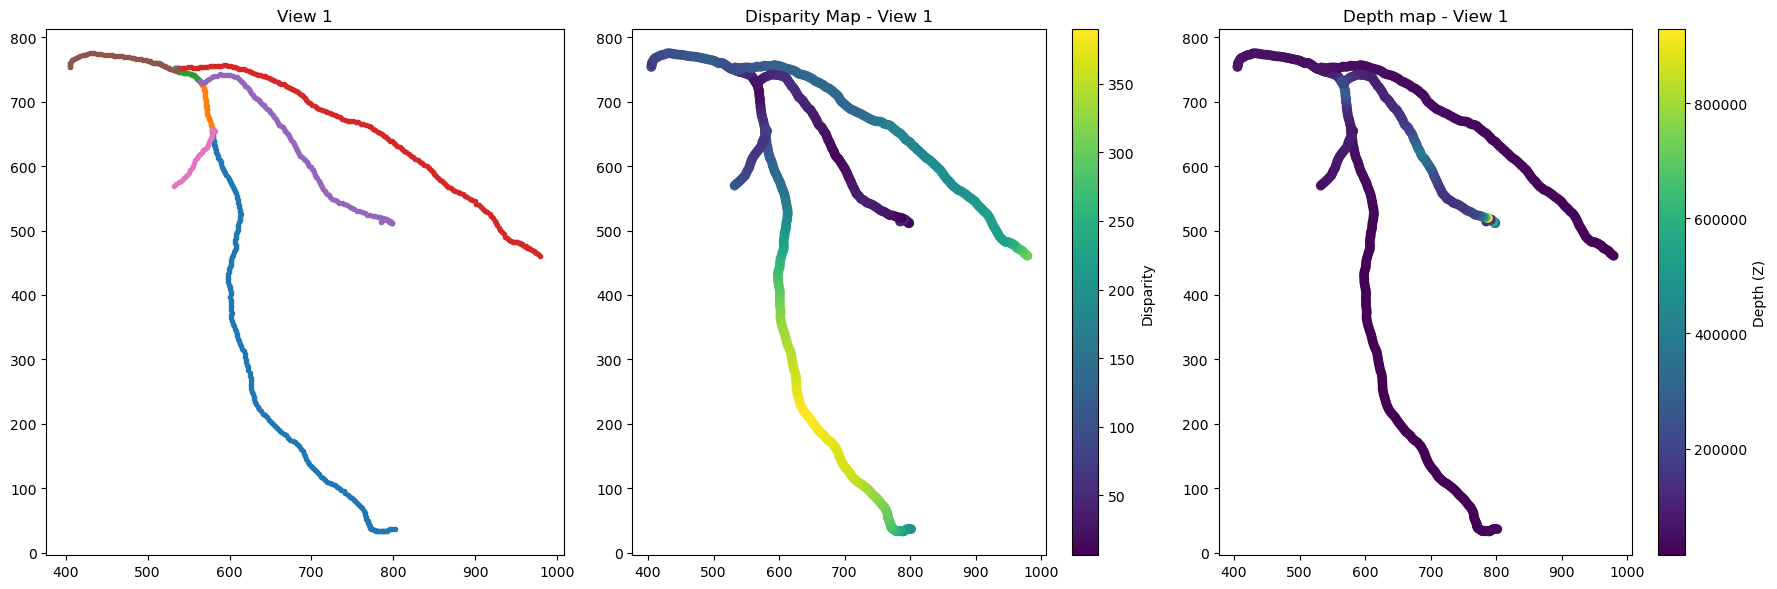

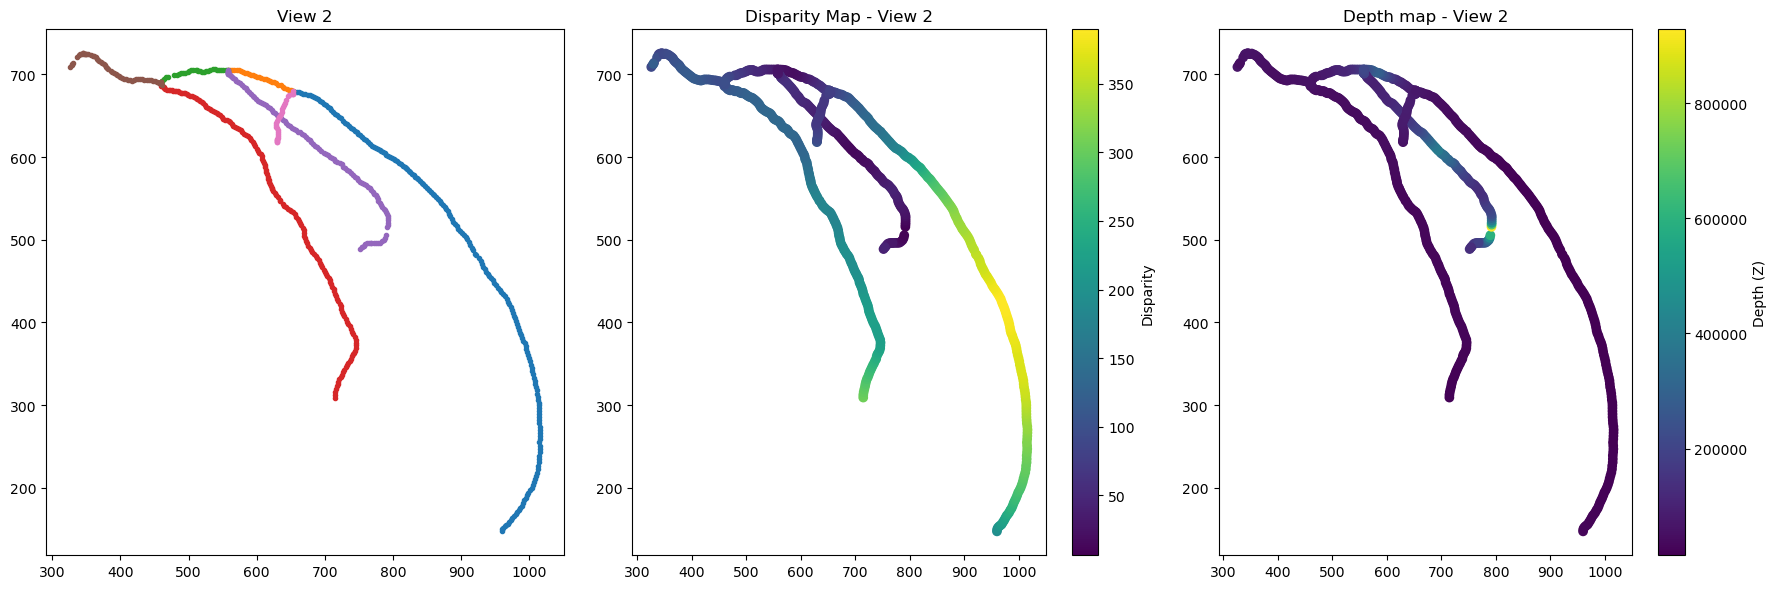

In [248]:
#from sklearn.metrics import r2_score
def compute_disparity(points_0:np.ndarray, points_1:np.ndarray) -> np.ndarray:
    """
    Computes disparity

    Parameters
    ----------
    points_0 : np.ndarray
        Points in first view, shape (N, 2)
    points_1 : np.ndarray
        Points in second view, shape (N, 2)

    Returns
    -------
    np.ndarray
        Disparity per point, shape (N, )
    """
    # TODO : compute disparity
    return np.linalg.norm(points_0-points_1,axis=1)

def compute_depth(disparities:np.ndarray, f:float, b:float) -> np.ndarray:
    """
    Computes depth using disparity measurement

    Parameters
    ----------
    disparities : np.ndarray
        Disparity measurement, shape (N, )
    f : float
        Focal length of the camera
    b : float
        Distance between the two cameras

    Returns
    -------
    np.ndarray
        Depth associated to each point in disparity map, shape (N, )
    """
    # TODO : compute depth
    #Z=f*B/d
    return (f*b)/disparities
#f=sid*dp/sod#sid/dp#sid*dp/sod #in pixels
f= params_1['source']['f']
# print(params_1['source']['f']) -> same as 2
# print(params_2['source']['f'])
#f est dans les param
# print(f)
# print(params_1['source']['K'][0, 0])
#B = np.linalg.norm(T_s)
#B distance entre les 2 (différence de 2 params)
#B = np.linalg.norm(T-T_prime)
B= np.linalg.norm(params_1['source']['world_position'] - params_2['source']['world_position'])
print(B)
# TODO : print B, correlation metrics between real depth and estimated depth
# TODO : display both views (1 and matched points in 2), and for each view add the disparity map and the depth map. That's a total of 6 figures
print("B, correlation metrics between real depth and estimated depth:")
print(B)
disparities=compute_disparity(view1_points, view2_points)

Z = compute_depth(disparities, f, B)
#correlation = r2_score(real_depth, Z)


def depth_disp_map(points, disparities, depths, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create side-by-side subplots
    
    # Original view
    for branch_idx in np.unique(mesh.skeleton_labels):
        pts = points[mesh.skeleton_labels == branch_idx]
        axes[0].plot(pts[:,0], pts[:,1], '.')
        axes[0].set_title(f'{title}')
        
    # Disparity map
    sc1 = axes[1].scatter(points[:, 0], points[:, 1], c=disparities, cmap='viridis')
    fig.colorbar(sc1, ax=axes[1], label='Disparity')
    axes[1].set_title(f"Disparity Map - {title}")
    
    # Depth map
    sc2 = axes[2].scatter(points[:, 0], points[:, 1], c=depths, cmap='viridis')
    fig.colorbar(sc2, ax=axes[2], label='Depth (Z)')
    axes[2].set_title(f"Depth map - {title}")
    
    plt.tight_layout()
    plt.show()

depth_disp_map(view1_points, disparities, Z, "View 1")
depth_disp_map(view2_points, disparities, Z, "View 2")


In [249]:
#T0, T1, new_P0, new_P1 = None # TODO : calculate transformation matrices and rectified projection matrices for both views using hearttools.utils.rectify
#Rectify function : Rectify two projection matrices.
# Arguments:
# po1 np.ndarray - First projection matrix.
# po2 np.ndarray - Second projection matrix.
# tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
# Transformation matrix for the first projection matrix.
# Transformation matrix for the second projection matrix.
# New projection matrix for the first camera.
# New projection matrix for the second camera.
T0, T1, new_P0, new_P1 = hearttools.utils.rectify(params_1['source']['P'], params_2['source']['P'])

In [250]:

pts_2d_view_1_rectif = (T0 @ hearttools.geometry.to_homogeneous(view1_points).T).T # TODO : apply transformation matrix to view 1 points
pts_2d_view_2_rectif = (T1 @ hearttools.geometry.to_homogeneous(view2_points).T).T# TODO : apply transformation matrix to view 2 sampled points
pts_2d_view_1_rectif = pts_2d_view_1_rectif[:, :2]/pts_2d_view_1_rectif[:, 2][:, np.newaxis]
pts_2d_view_2_rectif = pts_2d_view_2_rectif[:, :2]/pts_2d_view_2_rectif[:, 2][:, np.newaxis]


In [251]:
#To rectify the images: you should get the same result, whether you use the rectifying 
# transformations T1 and T2, or whether you use the projection matrices Pn1 and Pn2, that are 
# all output by the function Rectify(Po1,Po2). In the first case, you apply the transformations 
# to the original image points (actually, those resulting from Q2 for View 2 after resampling & 
# matching) to get their rectified positions. In the second case, you project the 3D model to get 
# the 2D point positions in the rectified images

pts_2d_view_1_rectif_T = (T0 @ hearttools.geometry.to_homogeneous(view1_points).T).T
pts_2d_view_2_rectif_T = (T1 @ hearttools.geometry.to_homogeneous(view2_points).T).T
pts_2d_view_1_rectif_T = pts_2d_view_1_rectif_T[:, :2] / pts_2d_view_1_rectif_T[:, 2][:, np.newaxis]
pts_2d_view_2_rectif_T = pts_2d_view_2_rectif_T[:, :2] / pts_2d_view_2_rectif_T[:, 2][:, np.newaxis]
pts_2d_view_1_rectif_P = (new_P0@ hearttools.geometry.to_homogeneous(mesh.skeleton).T).T
pts_2d_view_2_rectif_P = (new_P1 @ hearttools.geometry.to_homogeneous(mesh.skeleton).T).T
pts_2d_view_1_rectif_P = pts_2d_view_1_rectif_P[:, :2] / pts_2d_view_1_rectif_P[:, 2][:, np.newaxis]
pts_2d_view_2_rectif_P = pts_2d_view_2_rectif_P[:, :2] / pts_2d_view_2_rectif_P[:, 2][:, np.newaxis]
print( np.linalg.norm(pts_2d_view_1_rectif_T - pts_2d_view_1_rectif_P))
print(np.linalg.norm(pts_2d_view_2_rectif_T - pts_2d_view_2_rectif_P))
# pts_2d_view_2_rectif=pts_2d_view_2_rectif_P 

2.2510711577373378e-11
142.9049740145274


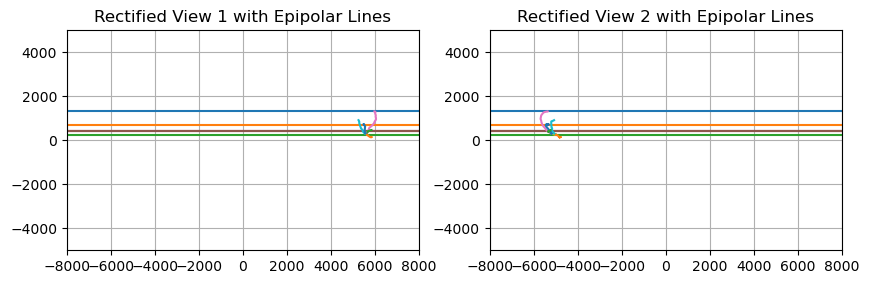

In [252]:
"""
FIGURE SETUP, DO NOT TOUCH
"""
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Rectified View 1 with Epipolar Lines")
ax[1].set_title("Rectified View 2 with Epipolar Lines")

for a in [ax[0], ax[1]]:
    a.set_aspect('equal', adjustable='box') # ? Set the aspect ratio
    a.grid() # ? Add the grid
    a.set_xlim(-8000, 8000) # ? Set the limits
    a.set_ylim(-5000, 5000)
"""
END OF FIGURE SETUP
"""


sample_points_rectified = pts_2d_view_1_rectif[::len(pts_2d_view_1_rectif) // 5, :]
x_vals = np.linspace(-10000, 10000, 100)
for point in sample_points_rectified:
    y_val = point[1]
    ax[0].plot(x_vals, y_val*np.ones_like(x_vals))  
    ax[1].plot(x_vals, y_val*np.ones_like(x_vals))  


# Plot coronary branches
for branch_idx in np.unique(mesh.skeleton_labels): 
    pts1 = pts_2d_view_1_rectif[mesh.skeleton_labels == branch_idx]
    ax[0].plot(pts1[:,0], pts1[:,1])
    pts2 = pts_2d_view_2_rectif[mesh.skeleton_labels == branch_idx]
    ax[1].plot(pts2[:,0], pts2[:,1])
    
plt.show()
#on doit pas faire comme ça on doit juste prendre horizontale sachant qu'ils sont sur la même ligne


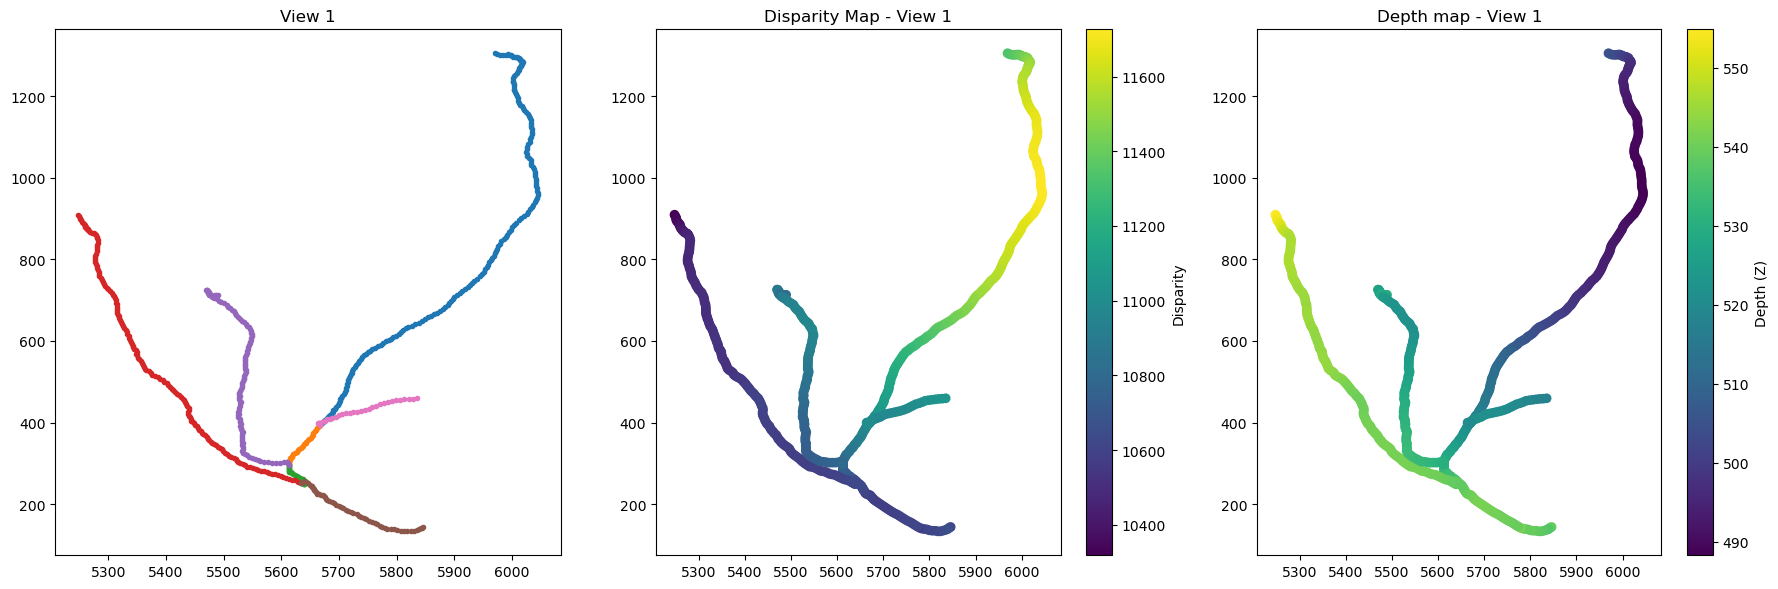

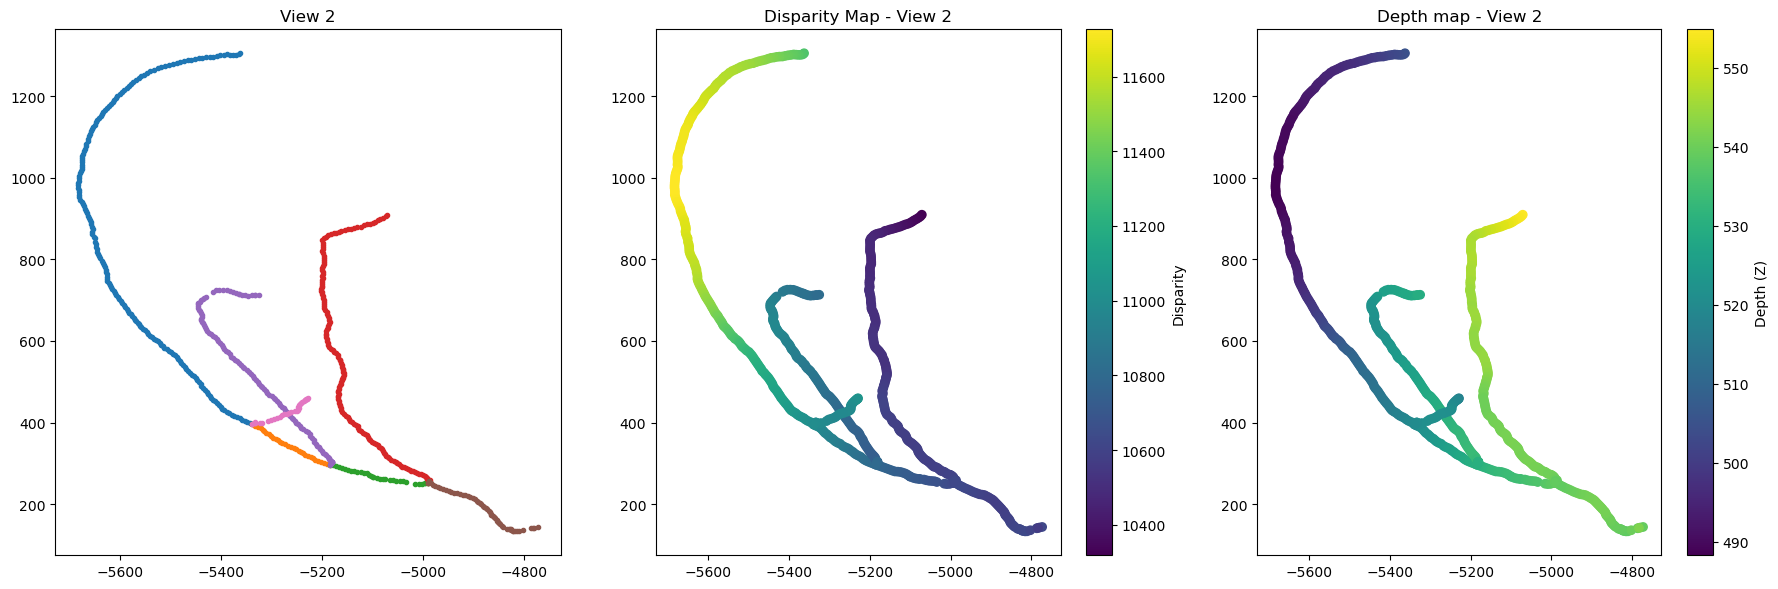

In [253]:
# TODO : print B, correlation metrics between real depth and estimated depth
# TODO : display both views (1 rectified and matched points in 2 rectified), and for each view add the disparity map and the depth map. That's a total of 6 figures
d_rectif= compute_disparity(pts_2d_view_1_rectif, pts_2d_view_2_rectif)
Z_rectif=compute_depth(d_rectif, f, B)
depth_disp_map(pts_2d_view_1_rectif, d_rectif, Z_rectif, "View 1")
depth_disp_map(pts_2d_view_2_rectif, d_rectif, Z_rectif, "View 2")

# Question 4

In [254]:
# TODO : Calculate the DLT coefficients (think about their meaning, you already have them, just in the wrong shape)
# dlt_v1 = None
# dlt_v2 = None
#only reshape the prpjections matrices into 1D form so that it alligns with the DLT coefficients
#relation entre les points 2D et 3D
dlt_v1 = params_1['source']['P'].flatten() 
dlt_v2 = params_2['source']['P'].flatten() 
dlt_v1/=dlt_v1[-1]
dlt_v2/=dlt_v2[-1]
print("DLT for view 1:", dlt_v1)
print("DLT for view 2:", dlt_v2)
#dernier param doit être égal à 1 -> tout diviser par le dernier



DLT for view 1: [ 5.89871435e+00 -2.88507400e-01  4.12004460e+00  5.12000000e+02
 -1.82411385e+00  6.20832261e+00  3.15945787e+00  5.12000000e+02
 -6.04205191e-04 -5.63491016e-04  1.04651409e-03  1.00000000e+00]
DLT for view 2: [ 5.48691206e+00  3.41333333e-01 -4.65081957e+00  5.12000000e+02
 -2.11638666e+00  6.54940074e+00 -2.11638666e+00  5.12000000e+02
  8.16496581e-04  6.66666667e-04  8.16496581e-04  1.00000000e+00]


In [255]:
#reconstruction_3d_DLT = None # TODO : using the non rectified views (view 1 and matched points in sampled view 2), perform the DLT reconstruction using hearttools.geometry.calculate_3d_point
#calculate_3_point structure in geometry : def calculate_3d_point(u0:float, v0:float, u1:float, v1:float, L0:np.ndarray, L1:np.ndarray) 
#i need to find the u and v for each view

reconstructed_3d_points=[]
for pt_view1, pt_view2 in zip(view1_points , view2_points ):
    #individual coord
    u0, v0 = pt_view1
    u1, v1 = pt_view2
    pt_3d=hearttools.geometry.calculate_3d_point(u0,v0,u1,v1,dlt_v1,dlt_v2)
    reconstructed_3d_points.append(pt_3d)
reconstruction_3d_DLT = np.array(reconstructed_3d_points)

print(reconstruction_3d_DLT)





[[ 60.642593 -45.03221  -27.482409]
 [ 60.336086 -44.87393  -27.813145]
 [ 60.15713  -44.779285 -28.236889]
 ...
 [ 17.237438  29.625813 -11.14645 ]
 [ 17.224808  29.588047 -11.229409]
 [ 17.009432  30.002039 -11.539067]]


In [256]:
# ? View the figure

pc = hearttools.structures.Pointcloud(reconstruction_3d_DLT)
mesh.plot_compare(pc)

In [257]:
# ? 3D RMS error:
#erreur élevée
print('RMS for the DLT reconstruction:', hearttools.metrics.rms(mesh.skeleton, pc.vertices))


RMS for the DLT reconstruction: 0.37770889203349695


In [258]:
# TODO : perform the back reprojection of `reconstruction_3d_DLT` and measure the error compared to the ground truth
# reproj_v1 = None
# reproj_v2 = None
#backrpojection from 3D to homog coordinated
reproj_v1 = []
for pt_3d in reconstruction_3d_DLT:
    pt_3d_homog = np.append(pt_3d, 1) # ! don't forget to add a 1 in the matric (change of coordinates)
    proj_2d_homog = np.dot(dlt_v1.reshape(3, 4), pt_3d_homog)
    reproj_v1.append(proj_2d_homog[:2]/proj_2d_homog[2]) 
reproj_v2 = []
for pt_3d in reconstruction_3d_DLT:
    pt_3d_homog = np.append(pt_3d, 1) # ! don't forget to add a 1 in the matric (change of coordinates)
    proj_2d_homog = np.dot(dlt_v2.reshape(3, 4), pt_3d_homog)
    reproj_v2.append(proj_2d_homog[:2]/proj_2d_homog[2]) 
#error with rms -> so convert into arrays 
reproj_v1 = np.array(reproj_v1)
reproj_v2 = np.array(reproj_v2)
error_v1 = hearttools.metrics.rms(view1_points, reproj_v1)
error_v2 = hearttools.metrics.rms(view2_points, reproj_v2)

print("Erreur RMS pour la vue 1 :", error_v1)
print("Erreur RMS pour la vue 2 :", error_v2)

Erreur RMS pour la vue 1 : 0.22453414711192538
Erreur RMS pour la vue 2 : 0.20989695105419098


In [259]:
import numpy as np
import plotly.graph_objects as go

def add_noise(parameter:float, percentage:float) -> float:
    """
    Adds uniform-sampled noise to the original parameter with respect to its primary value

    Parameters
    ----------
    parameter : float
        Parameter original value
    percentage : float
        Amplitude of the noise

    Returns
    -------
    float
        Modified parameter value
    """
    noise = np.random.uniform(-percentage/100*parameter, percentage/100*parameter)
    return float(parameter+noise)

# TODO : add up to 10% noise, and measure RMS everytime, then plot it

noise_levels = np.arange(0, 11)
num_trials = 10  

# I want plots as in the slide -> store for 2D : u,v and total, for 3D: X,Y,Z,total
rms_errors_v1_total, rms_errors_v1_u, rms_errors_v1_v = [], [], []
rms_errors_v2_total, rms_errors_v2_u, rms_errors_v2_v = [], [], []
rms_errors_3d_total, rms_errors_3d_x, rms_errors_3d_y, rms_errors_3d_z = [], [], [], []

#comment are based on the steps in additional_statement
for noise in noise_levels:
    #intermediate, before averaging
    v1_total, v1_u, v1_v = [], [], []
    v2_total, v2_u, v2_v = [], [], []
    d3_total, d3_x, d3_y, d3_z = [], [], [], []

    for _ in range(num_trials):
        # Add noise to DICOM parameters
        sid_noisy = add_noise(sid, noise)
        sod_noisy = add_noise(sod, noise)
        dp_noisy = add_noise(dp, noise)
        alpha_0_noisy = add_noise(alpha_0, noise)
        beta_0_noisy = add_noise(beta_0, noise)
        alpha_1_noisy = add_noise(alpha_1, noise)
        beta_1_noisy = add_noise(beta_1, noise)

        # Generate noisy calibration parameters
        params_1_noisy = hearttools.geometry.build_view_geometry(sid_noisy, sod_noisy, dp_noisy, alpha_0_noisy, beta_0_noisy, (1024, 1024))
        params_2_noisy = hearttools.geometry.build_view_geometry(sid_noisy, sod_noisy, dp_noisy, alpha_1_noisy, beta_1_noisy, (1024, 1024))
        dlt_v1_noisy = params_1_noisy['source']['P'].flatten() / params_1_noisy['source']['P'][-1, -1]
        dlt_v2_noisy = params_2_noisy['source']['P'].flatten() / params_2_noisy['source']['P'][-1, -1]

        # Reconstruct 3D model
        reconstructed_3d_points_noisy = []
        for pt_view1, pt_view2 in zip(view1_points, view2_points):
            u0, v0 = pt_view1
            u1, v1 = pt_view2
            pt_3d_noisy = hearttools.geometry.calculate_3d_point(u0, v0, u1, v1, dlt_v1_noisy, dlt_v2_noisy)
            reconstructed_3d_points_noisy.append(pt_3d_noisy)
        reconstruction_3d_DLT_noisy = np.array(reconstructed_3d_points_noisy)

        # Back-project to 2D
        #easier way than past, but is the same 
        #p_2D = [x'/w,y'/w]
        reproj_v1_noisy = np.array([np.dot(dlt_v1_noisy.reshape(3, 4), np.append(pt, 1))[:2] / np.dot(dlt_v1_noisy.reshape(3, 4), np.append(pt, 1))[2] for pt in reconstruction_3d_DLT_noisy])
        reproj_v2_noisy = np.array([np.dot(dlt_v2_noisy.reshape(3, 4), np.append(pt, 1))[:2] / np.dot(dlt_v2_noisy.reshape(3, 4), np.append(pt, 1))[2] for pt in reconstruction_3d_DLT_noisy])

        # Calculate RMS errors
        v1_total.append(hearttools.metrics.rms(view1_points, reproj_v1_noisy))
        v1_u.append(hearttools.metrics.rms(view1_points[:, 0], reproj_v1_noisy[:, 0]))
        v1_v.append(hearttools.metrics.rms(view1_points[:, 1], reproj_v1_noisy[:, 1]))
        v2_total.append(hearttools.metrics.rms(view2_points, reproj_v2_noisy))
        v2_u.append(hearttools.metrics.rms(view2_points[:, 0], reproj_v2_noisy[:, 0]))
        v2_v.append(hearttools.metrics.rms(view2_points[:, 1], reproj_v2_noisy[:, 1]))
        d3_total.append(hearttools.metrics.rms(reconstruction_3d_DLT, reconstruction_3d_DLT_noisy))
        d3_x.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 0], reconstruction_3d_DLT_noisy[:, 0]))
        d3_y.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 1], reconstruction_3d_DLT_noisy[:, 1]))
        d3_z.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 2], reconstruction_3d_DLT_noisy[:, 2]))

    # average over the errors to avoid oscillations
    rms_errors_v1_total.append(np.mean(v1_total))
    rms_errors_v1_u.append(np.mean(v1_u))
    rms_errors_v1_v.append(np.mean(v1_v))
    rms_errors_v2_total.append(np.mean(v2_total))
    rms_errors_v2_u.append(np.mean(v2_u))
    rms_errors_v2_v.append(np.mean(v2_v))
    rms_errors_3d_total.append(np.mean(d3_total))
    rms_errors_3d_x.append(np.mean(d3_x))
    rms_errors_3d_y.append(np.mean(d3_y))
    rms_errors_3d_z.append(np.mean(d3_z))


#plot the curves as in the slides but by using go
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_u, mode='lines+markers', name='u', line=dict(shape='spline')))
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_v, mode='lines+markers', name='v', line=dict(shape='spline')))
fig1.update_layout(title='RMS plot for View 1', xaxis_title='Percentage error', yaxis_title='2D RMS Errors')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_u, mode='lines+markers', name='u', line=dict(shape='spline')))
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_v, mode='lines+markers', name='v', line=dict(shape='spline')))
fig2.update_layout(title='RMS plot for View 2', xaxis_title='Percentage error', yaxis_title='2D RMS Errors')

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_x, mode='lines+markers', name='X', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_y, mode='lines+markers', name='Y', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_z, mode='lines+markers', name='Z', line=dict(shape='spline')))
fig3.update_layout(title='RMS plot for 3D', xaxis_title='Percentage error', yaxis_title='3D RMS Errors')

fig1.show()
fig2.show()
fig3.show()


# Question 5

In [260]:
#do it again but with self-calibration, copy code of last questions but with small changes
noise_levels = np.arange(0, 11)
num_trials = 10  

rms_errors_v1_total, rms_errors_v1_u, rms_errors_v1_v = [], [], []
rms_errors_v2_total, rms_errors_v2_u, rms_errors_v2_v = [], [], []
rms_errors_3d_total, rms_errors_3d_x, rms_errors_3d_y, rms_errors_3d_z = [], [], [], []

for noise in noise_levels:  
    v1_total, v1_u, v1_v = [], [], []
    v2_total, v2_u, v2_v = [], [], []
    d3_total, d3_x, d3_y, d3_z = [], [], [], []
    for i in range(num_trials):
        sid_noisy = add_noise(sid, noise)
        sod_noisy = add_noise(sod, noise)
        dp_noisy = add_noise(dp, noise)
        alpha_0_noisy = add_noise(alpha_0, noise)
        beta_0_noisy = add_noise(beta_0, noise)
        alpha_1_noisy = add_noise(alpha_1, noise)
        beta_1_noisy = add_noise(beta_1, noise)
        params_1_noisy = hearttools.geometry.build_view_geometry(sid_noisy, sod_noisy, dp_noisy, alpha_0_noisy, beta_0_noisy, (image_size, image_size))
        params_2_noisy = hearttools.geometry.build_view_geometry(sid_noisy, sod_noisy, dp_noisy, alpha_1_noisy, beta_1_noisy, (image_size, image_size))
        #will be wrong if I use them as follow 
        # dlt_v1_noisy = params_1_noisy['source']['P'].flatten()/params_1_noisy['source']['P'][-1, -1]
        # dlt_v2_noisy = params_2_noisy['source']['P'].flatten()/params_2_noisy['source']['P'][-1, -1]
        # refined matrices, see in geometry for the structure of the function
        K_refined_v1, R_refined_v1, t_refined_v1 = hearttools.geometry.refine_cam_param(x=view1_points,X=reconstruction_3d_DLT,K=params_1_noisy['source']['K'],R=params_1_noisy['source']['R'],t=params_1_noisy['source']['T'])
        K_refined_v2, R_refined_v2, t_refined_v2 = hearttools.geometry.refine_cam_param(x=view2_points,X=reconstruction_3d_DLT,K=params_2_noisy['source']['K'],R=params_2_noisy['source']['R'],t=params_2_noisy['source']['T'])
        #don't use the dlt coefficients this time because I will have a new refined projection matrix
        #Projection matrice obtained as P= K *[R|t] -> all refined
        projec_matric_0 = np.dot(K_refined_v1, np.hstack((R_refined_v1, t_refined_v1))).flatten()
        projec_matric_1 = np.dot(K_refined_v2, np.hstack((R_refined_v2, t_refined_v2))).flatten()
        projec_matric_0 /= projec_matric_0[-1]
        projec_matric_1 /= projec_matric_1[-1]
        reconstructed_3d_points_refined = []
        for pt_view1, pt_view2 in zip(view1_points, view2_points):
            u0, v0 = pt_view1
            u1, v1 = pt_view2
            #only thing that change is here 
            pt_3d_refined = hearttools.geometry.calculate_3d_point(u0, v0, u1, v1,projec_matric_0, projec_matric_1)
            reconstructed_3d_points_refined.append(pt_3d_refined)
        reconstruction_3d_refined = np.array(reconstructed_3d_points_refined)
        #backproject but this time with refined matrices
        reproj_v1_refined = (K_refined_v1 @ (R_refined_v1 @ reconstruction_3d_refined.T + t_refined_v1)).T
        reproj_v2_refined = (K_refined_v2 @ (R_refined_v2 @ reconstruction_3d_refined.T + t_refined_v2)).T
        reproj_v1_refined = reproj_v1_refined[:, :2]/reproj_v1_refined[:, 2, np.newaxis]
        reproj_v2_refined = reproj_v2_refined[:, :2]/reproj_v2_refined[:, 2, np.newaxis]
        v1_total.append(hearttools.metrics.rms(view1_points, reproj_v1_refined))
        v1_u.append(hearttools.metrics.rms(view1_points[:, 0], reproj_v1_refined[:, 0]))
        v1_v.append(hearttools.metrics.rms(view1_points[:, 1], reproj_v1_refined[:, 1]))
        v2_total.append(hearttools.metrics.rms(view2_points, reproj_v2_refined))
        v2_u.append(hearttools.metrics.rms(view2_points[:, 0], reproj_v2_refined[:, 0]))
        v2_v.append(hearttools.metrics.rms(view2_points[:, 1], reproj_v2_refined[:, 1]))
        d3_total.append(hearttools.metrics.rms(reconstruction_3d_DLT, reconstruction_3d_refined))
        d3_x.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 0], reconstruction_3d_refined[:, 0]))
        d3_y.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 1], reconstruction_3d_refined[:, 1]))
        d3_z.append(hearttools.metrics.rms(reconstruction_3d_DLT[:, 2], reconstruction_3d_refined[:, 2]))
    rms_errors_v1_total.append(np.mean(v1_total))
    rms_errors_v1_u.append(np.mean(v1_u))
    rms_errors_v1_v.append(np.mean(v1_v))
    rms_errors_v2_total.append(np.mean(v2_total))
    rms_errors_v2_u.append(np.mean(v2_u))
    rms_errors_v2_v.append(np.mean(v2_v))
    rms_errors_3d_total.append(np.mean(d3_total))
    rms_errors_3d_x.append(np.mean(d3_x))
    rms_errors_3d_y.append(np.mean(d3_y))
    rms_errors_3d_z.append(np.mean(d3_z))


fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_u, mode='lines+markers', name='u', line=dict(shape='spline')))
fig1.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v1_v, mode='lines+markers', name='v', line=dict(shape='spline')))
fig1.update_layout(title='RMS plot for View 1 after Self-Calibration', xaxis_title='Percentage error', yaxis_title='2D RMS Errors')


fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_u, mode='lines+markers', name='u', line=dict(shape='spline')))
fig2.add_trace(go.Scatter(x=noise_levels, y=rms_errors_v2_v, mode='lines+markers', name='v', line=dict(shape='spline')))
fig2.update_layout(title='RMS plot for View 2 after Self-Calibration', xaxis_title='Percentage error', yaxis_title='2D RMS Errors')

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_total, mode='lines+markers', name='total', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_x, mode='lines+markers', name='X', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_y, mode='lines+markers', name='Y', line=dict(shape='spline')))
fig3.add_trace(go.Scatter(x=noise_levels, y=rms_errors_3d_z, mode='lines+markers', name='Z', line=dict(shape='spline')))
fig3.update_layout(title='RMS plot for 3D Reconstruction after Self-Calibration', xaxis_title='Percentage error', yaxis_title='3D RMS Errors')

fig1.show()
fig2.show()
fig3.show()


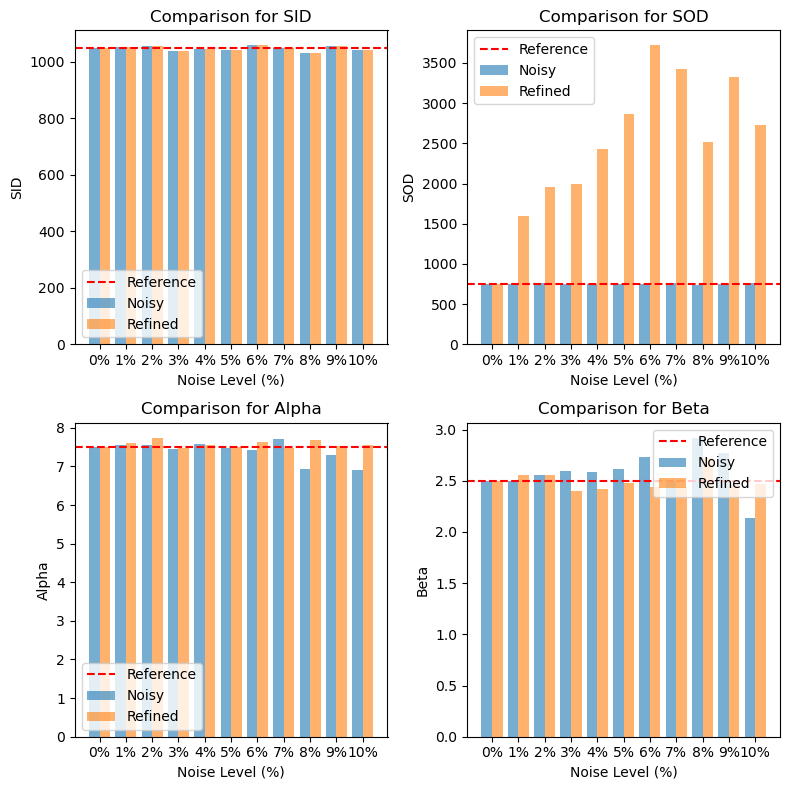

In [261]:
# TODO : For each parameter (SID, SOD, alpha_0, beta_0, alpha_1, beta_1), display a bar chart that, for every level of noise, compares the noisy value to the refined one (after self calibration). Display the reference value as a horizontal line
#same but this time we don't need to reconstruct or backproject, just retrieve my refined parameters
noise_levels = np.arange(0, 11)
num_trials = 10 

rms_errors_v1_total, rms_errors_v1_u, rms_errors_v1_v = [], [], []
rms_errors_v2_total, rms_errors_v2_u, rms_errors_v2_v = [], [], []
rms_errors_3d_total, rms_errors_3d_x, rms_errors_3d_y, rms_errors_3d_z = [], [], [], []
sid_refined_vals, sod_refined_vals = [], []
alpha_refined_vals, beta_refined_vals = [], []
sid_noisy_vals, sod_noisy_vals = [], []
alpha_noisy_vals, beta_noisy_vals = [], []

# reference values 
sid_ref, sod_ref, dp_ref = sid, sod, dp
alpha_0_ref, beta_0_ref = alpha_0, beta_0
alpha_1_ref, beta_1_ref = alpha_1, beta_1


for noise in noise_levels:
    rms_v1_total, rms_v1_u, rms_v1_v = [], [], []
    rms_v2_total, rms_v2_u, rms_v2_v = [], [], []
    rms_3d_total, rms_3d_x, rms_3d_y, rms_3d_z = [], [], [], []
    
    sid_noisy, sod_noisy = [], []
    alpha_noisy, beta_noisy = [], []
    sid_refined, sod_refined = [], []
    alpha_refined, beta_refined = [], []
    
    for _ in range(num_trials):
        # Add noise to DICOM parameters
        sid_noisy_val = add_noise(sid_ref, noise)
        sod_noisy_val = add_noise(sod_ref, noise)
        dp_noisy_val = add_noise(dp_ref, noise)
        alpha_0_noisy_val = add_noise(alpha_0_ref, noise)
        beta_0_noisy_val = add_noise(beta_0_ref, noise)
        alpha_1_noisy_val = add_noise(alpha_1_ref, noise)
        beta_1_noisy_val = add_noise(beta_1_ref, noise)
        
        params_1_noisy = hearttools.geometry.build_view_geometry(sid_noisy_val, sod_noisy_val, dp_noisy_val, alpha_0_noisy_val, beta_0_noisy_val, (1024, 1024))
        params_2_noisy = hearttools.geometry.build_view_geometry(sid_noisy_val, sod_noisy_val, dp_noisy_val, alpha_1_noisy_val, beta_1_noisy_val, (1024, 1024))
        dlt_v1_noisy = params_1_noisy['source']['P'].flatten() / params_1_noisy['source']['P'][-1, -1]
        dlt_v2_noisy = params_2_noisy['source']['P'].flatten() / params_2_noisy['source']['P'][-1, -1]

        # self-calibration
        K_refined_1, R_refined_1, T_refined_1 = hearttools.geometry.refine_cam_param(view1_points, reconstruction_3d_DLT, params_1_noisy['source']['K'], params_1_noisy['source']['R'], params_1_noisy['source']['T'])
        K_refined_2, R_refined_2, T_refined_2 = hearttools.geometry.refine_cam_param(view2_points, reconstruction_3d_DLT, params_2_noisy['source']['K'], params_2_noisy['source']['R'], params_2_noisy['source']['T'])
        
        #retrive my parameters
        sid_ref_1, sod_ref_1, alpha_0_refined, beta_0_refined = hearttools.utils.get_dicom_from_calib(K_refined_1, R_refined_1, T_refined_1, dp_noisy_val)
        sid_ref_2, sod_ref_2, alpha_1_refined, beta_1_refined = hearttools.utils.get_dicom_from_calib(K_refined_2, R_refined_2, T_refined_2, dp_noisy_val)
        
        sid_refined.append((sid_ref_1 + sid_ref_2) / 2)
        sod_refined.append((sod_ref_1 + sod_ref_2) / 2)
        alpha_refined.append((alpha_0_refined + alpha_1_refined) / 2)
        beta_refined.append((beta_0_refined + beta_1_refined) / 2)
        
        sid_noisy.append(sid_noisy_val)
        sod_noisy.append(sod_noisy_val)
        alpha_noisy.append((alpha_0_noisy_val + alpha_1_noisy_val) / 2)
        beta_noisy.append((beta_0_noisy_val + beta_1_noisy_val) / 2)
  
    sid_noisy_vals.append(np.mean(sid_noisy))
    sod_noisy_vals.append(np.mean(sod_noisy))
    alpha_noisy_vals.append(np.mean(alpha_noisy))
    beta_noisy_vals.append(np.mean(beta_noisy))
    sid_refined_vals.append(np.mean(sid_refined))
    sod_refined_vals.append(np.mean(sod_refined))
    alpha_refined_vals.append(np.mean(alpha_refined))
    beta_refined_vals.append(np.mean(beta_refined))


fig, axes = plt.subplots(2, 2, figsize=(8, 8))

bar_width = 0.4 
params = [("SID", sid_noisy_vals, sid_refined_vals, sid_ref),
          ("SOD", sod_noisy_vals, sod_refined_vals, sod_ref),
          ("Alpha", alpha_noisy_vals, alpha_refined_vals, (alpha_0_ref + alpha_1_ref) / 2),
          ("Beta", beta_noisy_vals, beta_refined_vals, (beta_0_ref + beta_1_ref) / 2)]

x = np.arange(len(noise_levels)) 

for ax, (name, noisy, refined, ref) in zip(axes.flatten(), params):
    ax.bar(x - bar_width / 2, noisy, bar_width, label='Noisy', alpha=0.6)
    ax.bar(x + bar_width / 2, refined, bar_width, label='Refined', alpha=0.6)
    ax.axhline(y=ref, color='red', linestyle='--', label='Reference')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{lvl}%" for lvl in noise_levels])
    ax.set_title(f"Comparison for {name}")
    ax.set_xlabel("Noise Level (%)")
    ax.set_ylabel(name)
    ax.legend()

plt.tight_layout()
plt.show()


In [262]:
# TODO : For each parameter (SID, SOD, alpha_0, beta_0, alpha_1, beta_1), display a bar chart that, for every level of noise, compares the noisy value to the refined one (after self calibration). Display the reference value as a horizontal line